In [61]:
import os
import hopsworks
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from matplotlib import pyplot
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from hsml.schema import Schema
from hsml.model_schema import ModelSchema



In [62]:
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/5295
Connected. Call `.close()` to terminate connection gracefully.


In [63]:
try:
    fview = fs.get_feature_view(name="nyc_electricity", version=1)
except:
    fg = fs.get_feature_group(name="nyc_electricity", version=1)
    query = fg.select_except(["date"]) # date not needed for training
    fview = fs.create_feature_view(name="nyc_electricity", 
                                            version=1, 
                                            description="Read from NYC electricity dataset", 
                                            labels=["demand"], # predict demand
                                            query=query)

In [64]:
# Hyperparameter search
seed = np.random.RandomState(65)
seed.rand()

0.21864505014720603

In [65]:
#X_train, X_test, y_train, y_test = fview.create_train_test_split(test_size=0.2)
X_train, X_test, y_train, y_test = fview.train_test_split(0.2)

2023-01-04 22:33:37,904 INFO: USE `id2223_ayushman_featurestore`
2023-01-04 22:33:38,432 INFO: SELECT `fg0`.`temperature` `temperature`, `fg0`.`demand` `demand`, `fg0`.`day` `day`, `fg0`.`month` `month`, `fg0`.`holiday` `holiday`
FROM `id2223_ayushman_featurestore`.`nyc_electricity_1` `fg0`


In [66]:
X_train.head(5)

,temperature,day,month,holiday
0,30.8,2,7,0
1,10.9,5,4,0
2,15.8,2,10,0
3,7.4,3,11,0
4,29.2,3,8,0


In [67]:
y_train.head(5)

,demand
0,219115
1,103204
2,127824
3,132941
4,195957


In [68]:
X_test.head(5)

,temperature,day,month,holiday
5,12.1,6,4,0
21,13.1,3,5,0
28,4.7,4,2,0
30,5.0,0,2,0
41,1.7,4,12,1


In [69]:
y_test.head(5)

,demand
5,105602
21,123486
28,135744
30,139220
41,124106


In [70]:
# re-usable data prep pipeline, avoids having info leaks from test splits in cross-validation
# update feature filter if needed
cols = ['temperature']

# TODO: data prep necessary? (probably enough to normalize/discretize temperature)

prepare = Pipeline([
    ('impute', SimpleImputer()), # needed?
    ('scale', MinMaxScaler()), # [0..1]
    ('discretize', KBinsDiscretizer(n_bins=10, encode='ordinal'))])

column_trans = ColumnTransformer([
    ('prepare', prepare, cols)],
    remainder='passthrough', # leave other cols as-is
    verbose_feature_names_out=False)

In [71]:
kf = RepeatedKFold(n_splits=10, random_state=seed)

In [72]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=seed) # default metric

xgb_pipeline = Pipeline([
    ('data_prep', column_trans),
    ('xgb', xgb)
]) # data prep defined as pipeline so each CV split is fitted to training split only

params = {
    # TODO: we could parametrize data prep too and test some combinations
    # TODO: check params for search grid
    'xgb__learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'xgb__max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'xgb__min_child_weight': [1, 3, 5, 7],
    'xgb__gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
    'xgb__colsample_bytree': [0.3, 0.4, 0.5 , 0.7]
}

In [73]:
gs_xgb = RandomizedSearchCV(xgb_pipeline,
                            random_state=seed,
                            param_distributions=params,
                            cv=kf,
                            verbose=3,
                            n_jobs=-1)

In [74]:
gs_xgb.fit(X_train, y_train)

Fitting 100 folds for each of 10 candidates, totalling 1000 fits


/Users/akzn/miniconda3/envs/venv_serverless-ml-intro/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/akzn/miniconda3/envs/venv_serverless-ml-intro/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/akzn/miniconda3/envs/venv_serverless-ml-intro/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/akzn/miniconda3/envs/venv_serverless-ml-intro/lib/python3.8/site-packages/xgboost/compat.py:3

[CV 2/100] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=1;, score=0.901 total time=   1.1s
[CV 5/100] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=1;, score=0.825 total time=   1.1s
[CV 3/100] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=1;, score=0.880 total time=   1.1s
[CV 8/100] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=1;, score=0.878 total time=   1.1s
[CV 6/100] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=1;, score=0.881 total time=   1.2s
[CV 4/100] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=1;, score=0.871 total time=   1.2s
[CV 7/100] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, 

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=10,
       random_state=RandomState(MT19937) at 0x7FE245778140),
                   estimator=Pipeline(steps=[('data_prep',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('prepare',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer()),
                                                                                               ('scale',
                                                                                                MinMaxScaler()),
                                                                                               ('discretize',
                                                                                                KBinsDiscretizer(encode='ordinal',
                                                                                                                 n_bins=10))]),
                                                                               ['...
                                                           tree_method=None,
                                                           validate_parameters=None,
                                                           verbosity=None))]),
                   n_jobs=-1,
                   param_distributions={'xgb__colsample_bytree': [0.3, 0.4, 0.5,
                                                                  0.7],
                                        'xgb__gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'xgb__learning_rate': [0.05, 0.1, 0.15,
                                                               0.2, 0.25, 0.3],
                                        'xgb__max_depth': [3, 4, 5, 6, 8, 10,
                                                           12, 15],
                                        'xgb__min_child_weight': [1, 3, 5, 7]},
                   random_state=RandomState(MT19937) at 0x7FE245778140,
                   verbose=3)

In [75]:
display(gs_xgb.best_params_)
display(gs_xgb.best_score_)

{'xgb__min_child_weight': 3,
 'xgb__max_depth': 4,
 'xgb__learning_rate': 0.1,
 'xgb__gamma': 0.3,
 'xgb__colsample_bytree': 0.5}

0.8715880096161729

In [76]:
# get best model
model = gs_xgb.best_estimator_

In [79]:
# get predictions for test set to get a performance estimate for unseen data
# best model is already re-trained on whole training data! (default for refit=True)
y_pred = model.predict(X_test)
mean_error = mean_absolute_error(y_test, y_pred)
display(mean_error) # MWh

6830.496289816602

TypeError: only size-1 arrays can be converted to Python scalars

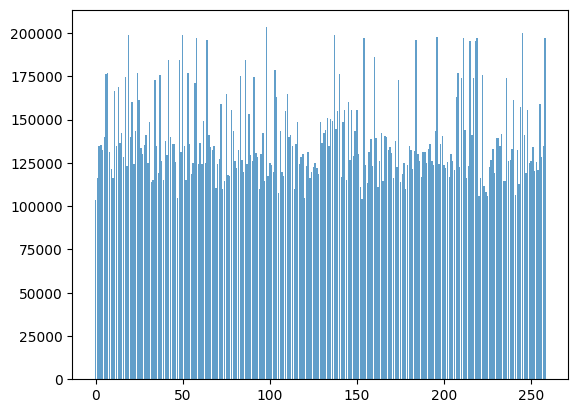

In [81]:
pyplot.bar(x=np.arange(len(y_pred)), height=y_pred, label='predicted', alpha=0.7)
pyplot.bar(x=np.arange(len(y_pred)), height=y_test.to_numpy(), label='expected', alpha=0.7)
pyplot.legend()
pyplot.show() # this representation doesn't make a lot of sense 🤷‍♂️

In [ ]:
# retrain model on whole set
#model.fit(X, y) # reminder: "model" contains whole pipeline including data prep!

# TODO: confusion matrix?
# TODO: historical record table?

In [82]:
# Store model on hopsworks
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [83]:
model_dir = "model"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

In [84]:
joblib.dump(model, model_dir + "/nyc_electricity_model.pkl")

['model/nyc_electricity_model.pkl']

In [85]:
# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

In [86]:
# Create an entry in the model registry that includes the model's name, desc, metrics
nyc_elec_model = mr.python.create_model(
    name="nyc_electricity_model",
    metrics={"mean_absolute_error": mean_error},
    model_schema=model_schema,
    description="NYC Electricity Demand Predictor"
)

In [87]:
# Upload to hopsworks
nyc_elec_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/5295/models/nyc_electricity_model/1


Model(name: 'nyc_electricity_model', version: 1)